In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import MNLogit
from tqdm import tqdm
from itertools import product

# Data

In [3]:
df = pd.read_csv("C:/Users/user/Desktop/Seminar/Hapiness survey/Total.csv",sep=';')

In [4]:
df.head()

,version,doi,A_YEAR,B_COUNTRY,B_COUNTRY_ALPHA,C_COW_NUM,C_COW_ALPHA,D_INTERVIEW,J_INTDATE,FW_START,...,DE_Q276a,DE_Q276b,DE_Q277,DE_Q277a,DE_Q277b,DE_Q278,DE_Q278a,DE_Q278b,DE_Q279,DE_Q280
0,1-5-0 (2020-11-16),doi.org/10.14281/18241.1,2018,276,DEU,255,GMY,276070001,20180305,201710,...,-3,-3,3,1,1,3,1,6,1,-3
1,1-5-0 (2020-11-16),doi.org/10.14281/18241.1,2018,276,DEU,255,GMY,276070002,20171110,201710,...,-3,-3,6,1,4,6,1,10,7,-3
2,1-5-0 (2020-11-16),doi.org/10.14281/18241.1,2018,276,DEU,255,GMY,276070003,20171121,201710,...,-3,-3,3,1,6,6,1,7,5,-3
3,1-5-0 (2020-11-16),doi.org/10.14281/18241.1,2018,276,DEU,255,GMY,276070004,20171106,201710,...,1,5,3,1,1,3,1,1,5,5
4,1-5-0 (2020-11-16),doi.org/10.14281/18241.1,2018,276,DEU,255,GMY,276070005,20180215,201710,...,1,6,2,1,6,2,1,1,5,5


In [8]:
df_research = df[['Q46','Q1','Q3','Q4','Q6','Q43','Q47','Q50','Q69','Q263','Q275R']].dropna().astype(int)

df_research = df_research.apply(pd.to_numeric, errors='coerce')
df_research = df_research[df_research.ge(0).all(axis=1)]
df_research.columns = ['Happiness', 'Family', 'Leisure_time', 'Politics', 'Religion', 'Work_Importance_(Future)', 'Health', 'Financial_satisfaction', 'Police', 'Immigrant?', 'Educ']
df_research.describe()

X_full = df_research.drop(columns='Happiness')
X_full = pd.get_dummies(X_full, drop_first=True)
Y_full = df_research['Happiness']
Y_full = Y_full.replace({4: 3})

In [10]:
X_full

,Family,Leisure_time,Politics,Religion,Work_Importance_(Future),Health,Financial_satisfaction,Police,Immigrant?,Educ
0,1,2,4,4,1,4,7,1,1,2
1,2,2,1,1,1,4,4,2,1,2
2,1,1,2,2,2,3,6,1,1,2
3,1,2,2,3,2,3,9,2,1,2
4,1,1,3,3,3,3,9,3,1,2
...,...,...,...,...,...,...,...,...,...,...
1523,1,2,2,4,1,2,7,1,2,2
1524,1,1,2,4,1,2,7,2,1,1
1525,1,2,3,2,1,3,7,1,1,3
1526,1,2,2,2,3,4,3,3,1,2


In [12]:
Y_full.value_counts(normalize=True)

Happiness
2    0.615866
1    0.280445
3    0.103688
Name: proportion, dtype: float64

In [14]:
df_research.isna().sum()

Happiness                   0
Family                      0
Leisure_time                0
Politics                    0
Religion                    0
Work_Importance_(Future)    0
Health                      0
Financial_satisfaction      0
Police                      0
Immigrant?                  0
Educ                        0
dtype: int64

<Axes: >

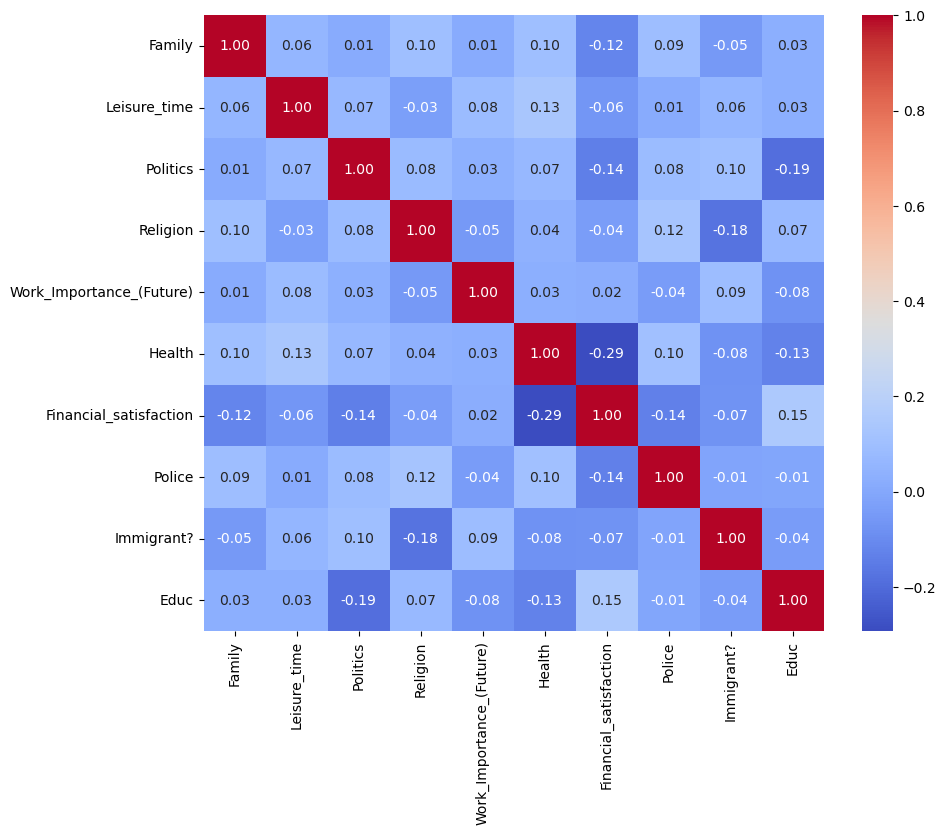

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = X_full.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
#plt.savefig("C:/Users/user/Desktop/Seminar/Excel_files/corr.png", dpi=300, bbox_inches='tight')

# 1) MNL with Delta-method

In [18]:
def run_mnl_estimation(X_full, Y_full, sample_size=None, n_features=None, random_state=42):

    np.random.seed(random_state)

    # Подвыборка по размеру, если задано
    if sample_size is not None and sample_size < len(X_full):
        X_full, Y_full = resample(X_full, Y_full, n_samples=sample_size, random_state=random_state)

    # Выбор признаков
    if n_features is not None:
        n_features = min(n_features, len(X_full.columns))
        selected_features = np.random.choice(X_full.columns, size=n_features, replace=False)
        X = X_full[selected_features]
    else:
        X = X_full.copy()

    X = sm.add_constant(X)

    # Оценка модели
    try:
        model = MNLogit(Y_full, X)
        result = model.fit(method='bfgs', maxiter=200, disp=False)
        mfx = result.get_margeff()
        mfx_df = mfx.summary_frame().reset_index()

        # Переименование колонок
        mfx_df = mfx_df.rename(columns={
            'dy/dx': 'mean_me',
            'Std. Err.': 'se_me',
            'Conf. Int. Low': 'ci_low',
            'Cont. Int. Hi.': 'ci_high',
            'Pr(>|z|)': 'p_value',
            'exog': 'predictor',
            'endog': 'outcome'
        })

        # Метки выборки
        mfx_df['sample_size'] = sample_size if sample_size is not None else len(X_full)
        mfx_df['n_features'] = n_features if n_features is not None else len(X.columns) - 1
        mfx_df['ci_length'] = mfx_df['ci_high'] - mfx_df['ci_low']
        mfx_df['significant'] = ~((mfx_df['ci_low'] < 0) & (mfx_df['ci_high'] > 0))

        return mfx_df

    except Exception as e:
        print(f"Model estimation failed: {e}")
        return None

In [20]:
sample_sizes = [200, 500, 1000, 1500]  # None = вся выборка
feature_counts = [3, 6, 10]         # None = все переменные

mnl_results = []

for sample_size in sample_sizes:
    for n_features in feature_counts:
        result = run_mnl_estimation(X_full, Y_full,
                                    sample_size=sample_size,
                                    n_features=n_features,
                                    random_state=42)
        if result is not None:
            result['sample_size'] = sample_size if sample_size is not None else len(X_full)
            result['n_features'] = n_features if n_features is not None else len(X_full.columns)
            mnl_results.append(result)

combined_mnl_results = pd.concat(mnl_results, ignore_index=True)
combined_mnl_results

,outcome,predictor,mean_me,se_me,z,p_value,ci_low,ci_high,sample_size,n_features,ci_length,significant
0,Happiness=1,Immigrant?,-0.171473,0.108207,-1.584681,1.130389e-01,-0.383554,0.040608,200,3,0.424162,False
1,Happiness=1,Leisure_time,-0.016955,0.050585,-0.335172,7.374951e-01,-0.116099,0.082190,200,3,0.198289,False
2,Happiness=1,Health,-0.089739,0.038475,-2.332409,1.967919e-02,-0.165149,-0.014330,200,3,0.150819,True
3,Happiness=2,Immigrant?,0.054294,0.110513,0.491295,6.232176e-01,-0.162307,0.270895,200,3,0.433202,False
4,Happiness=2,Leisure_time,0.018222,0.055072,0.330884,7.407320e-01,-0.089717,0.126162,200,3,0.215879,False
...,...,...,...,...,...,...,...,...,...,...,...,...
223,Happiness=3,Politics,-0.002654,0.009197,-0.288532,7.729393e-01,-0.020680,0.015373,1500,10,0.036053,False
224,Happiness=3,Educ,-0.007572,0.011991,-0.631495,5.277169e-01,-0.031075,0.015930,1500,10,0.047005,False
225,Happiness=3,Work_Importance_(Future),-0.019513,0.008015,-2.434614,1.490767e-02,-0.035223,-0.003804,1500,10,0.031418,True
226,Happiness=3,Religion,0.016639,0.007480,2.224396,2.612184e-02,0.001978,0.031301,1500,10,0.029323,True


In [22]:
combined_mnl_results

,outcome,predictor,mean_me,se_me,z,p_value,ci_low,ci_high,sample_size,n_features,ci_length,significant
0,Happiness=1,Immigrant?,-0.171473,0.108207,-1.584681,1.130389e-01,-0.383554,0.040608,200,3,0.424162,False
1,Happiness=1,Leisure_time,-0.016955,0.050585,-0.335172,7.374951e-01,-0.116099,0.082190,200,3,0.198289,False
2,Happiness=1,Health,-0.089739,0.038475,-2.332409,1.967919e-02,-0.165149,-0.014330,200,3,0.150819,True
3,Happiness=2,Immigrant?,0.054294,0.110513,0.491295,6.232176e-01,-0.162307,0.270895,200,3,0.433202,False
4,Happiness=2,Leisure_time,0.018222,0.055072,0.330884,7.407320e-01,-0.089717,0.126162,200,3,0.215879,False
...,...,...,...,...,...,...,...,...,...,...,...,...
223,Happiness=3,Politics,-0.002654,0.009197,-0.288532,7.729393e-01,-0.020680,0.015373,1500,10,0.036053,False
224,Happiness=3,Educ,-0.007572,0.011991,-0.631495,5.277169e-01,-0.031075,0.015930,1500,10,0.047005,False
225,Happiness=3,Work_Importance_(Future),-0.019513,0.008015,-2.434614,1.490767e-02,-0.035223,-0.003804,1500,10,0.031418,True
226,Happiness=3,Religion,0.016639,0.007480,2.224396,2.612184e-02,0.001978,0.031301,1500,10,0.029323,True


In [39]:
# Убедимся, что sample_size и n_features правильно сортируются (если есть строки с 'full_sample', 'all_features' — будут внизу)
combined_mnl_results_sorted = combined_mnl_results.sort_values(
    by=['sample_size', 'n_features', 'outcome', 'predictor']
).reset_index(drop=True)

In [ ]:
combined_mnl_results_sorted.to_excel("C:/Users/user/Desktop/Seminar/combined_mnl_results_sorted.xlsx", index=False)

# 2) Finding TRUE ME

In [286]:
# === 4. Добавляем константу в X ===
X_all = sm.add_constant(X_full)

# === 5. Оцениваем полную модель ===
model_full = MNLogit(Y_full, X_all)
result_full = model_full.fit(method='newton', maxiter=500, disp=True)

# === 6. Получаем маржинальные эффекты ===
mfx = result_full.get_margeff()
mfx_df = mfx.summary_frame().reset_index()
mfx_df.columns = ['predictor', 'outcome', 'dy/dx', 'std_err', 'z', 'p', 'ci_low', 'ci_high']

# === 7. Создаем словарь истинных ME по (predictor, outcome) ===
true_me_dict = mfx_df.set_index(['predictor', 'outcome'])['dy/dx'].to_dict()

# Посмотреть примеры:
from pprint import pprint
pprint(true_me_dict)

Optimization terminated successfully.
         Current function value: 0.752511
         Iterations 7
{('Happiness=1', 'Educ'): -0.00831526476542945,
 ('Happiness=1', 'Family'): -0.21464894368371668,
 ('Happiness=1', 'Financial_satisfaction'): 0.04642579365955513,
 ('Happiness=1', 'Health'): -0.09865448571844321,
 ('Happiness=1', 'Immigrant?'): 0.06642754205557723,
 ('Happiness=1', 'Leisure_time'): -0.04163931131973111,
 ('Happiness=1', 'Police'): -0.03548098550367248,
 ('Happiness=1', 'Politics'): 0.012153325310334627,
 ('Happiness=1', 'Religion'): -0.026344760164352322,
 ('Happiness=1', 'Work_Importance_(Future)'): -0.010121378635467427,
 ('Happiness=2', 'Educ'): 0.015892327447533643,
 ('Happiness=2', 'Family'): 0.1780185362540634,
 ('Happiness=2', 'Financial_satisfaction'): -0.02045613636398457,
 ('Happiness=2', 'Health'): 0.03684112430225062,
 ('Happiness=2', 'Immigrant?'): -0.12337154220580264,
 ('Happiness=2', 'Leisure_time'): 0.04444567280056212,
 ('Happiness=2', 'Police'): 0.00

In [288]:
# Преобразуем словарь в DataFrame
df_true_me = pd.DataFrame([
    {'outcome': k[0], 'predictor': k[1], 'true_dydx': v}
    for k, v in true_me_dict.items()
])

# Сохраняем в Excel
df_true_me.to_excel("C:/Users/user/Desktop/Seminar/true_marginal_effects.xlsx", index=False)

## True ME After meeting

In [88]:
# === 4. Добавляем константу в X ===
X_all = sm.add_constant(X_full)

# === 5. Оцениваем полную модель ===
model_full = MNLogit(Y_full, X_all)
result_full = model_full.fit(method='newton', maxiter=500, disp=True)

# === 6. Получаем маржинальные эффекты ===
mfx = result_full.get_margeff()
mfx_df = mfx.summary_frame().reset_index()
mfx_df.columns = ['outcome', 'predictor', 'dy/dx', 'std_err', 'z', 'p', 'ci_low', 'ci_high']

# === 7. Создаем DataFrame с истинными предельными эффектами и интервалами ===
df_true_me1 = mfx_df[['outcome', 'predictor', 'dy/dx', 'ci_low', 'ci_high']].copy()
df_true_me1 = df_true_me1.rename(columns={
    'dy/dx': 'true_dydx',
    'ci_low': 'true_ci_low',
    'ci_high': 'true_ci_high'
})

# Сохраняем в Excel
df_true_me1.to_excel("C:/Users/user/Desktop/Seminar/Excel_files_aftermeeting/true_marginal_effects1.xlsx", index=False)

Optimization terminated successfully.
         Current function value: 0.752511
         Iterations 7


In [90]:
df_true_me1

,outcome,predictor,true_dydx,true_ci_low,true_ci_high
0,Happiness=1,Family,-0.214649,-0.310151,-0.119147
1,Happiness=1,Leisure_time,-0.041639,-0.078452,-0.004827
2,Happiness=1,Politics,0.012153,-0.018702,0.043009
3,Happiness=1,Religion,-0.026345,-0.048617,-0.004072
4,Happiness=1,Work_Importance_(Future),-0.010121,-0.033445,0.013202
5,Happiness=1,Health,-0.098654,-0.125768,-0.071541
6,Happiness=1,Financial_satisfaction,0.046426,0.034516,0.058336
7,Happiness=1,Police,-0.035481,-0.070521,-0.000440
8,Happiness=1,Immigrant?,0.066428,0.005218,0.127637
9,Happiness=1,Educ,-0.008315,-0.043329,0.026699


## 2.1) Together

In [58]:
import pandas as pd

# === 1. Загрузим обе таблицы ===
combined_df = pd.read_excel("C:/Users/user/Desktop/Seminar/Excel_files/combined_mnl_results_sorted.xlsx")
true_me_df = pd.read_excel("C:/Users/user/Desktop/Seminar/Excel_files/true_marginal_effects.xlsx")

# === 2. Убедимся, что названия совпадают ===
# В combined_df: 'predictor', 'outcome'
# В true_me_df: 'predictor', 'outcome', 'true_dydx'

# === 3. Объединяем таблицы по двум ключам ===
combined_with_true = combined_df.merge(
    true_me_df,
    on=['predictor', 'outcome'],
    how='left'
)

# === 4. Добавляем колонку coverage (включает ли CI истинное значение) ===
combined_with_true['covered'] = (
    (combined_with_true['ci_low'] <= combined_with_true['true_dydx']) &
    (combined_with_true['true_dydx'] <= combined_with_true['ci_high'])
)

# === 5. Сохраняем результат ===
combined_with_true.to_excel("C:/Users/user/Desktop/Seminar/Excel_files/combined_delta_with_true_me.xlsx", index=False)

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/user/Desktop/Seminar/Excel_files/true_marginal_effects1.xlsx'

In [348]:
combined_with_true

,outcome,predictor,mean_me,se_me,z,p_value,ci_low,ci_high,sample_size,n_features,ci_length,significant,true_dydx,covered
0,Happiness=1,Health,-0.089739,0.038475,-2.332409,0.019679,-0.165149,-0.014330,200,3,0.150819,True,-0.098654,True
1,Happiness=1,Immigrant?,-0.171473,0.108207,-1.584681,0.113039,-0.383554,0.040608,200,3,0.424162,False,0.066428,False
2,Happiness=1,Leisure_time,-0.016955,0.050585,-0.335172,0.737495,-0.116099,0.082190,200,3,0.198289,False,-0.041639,True
3,Happiness=2,Health,0.009939,0.043434,0.228838,0.818995,-0.075190,0.095068,200,3,0.170258,False,0.036841,True
4,Happiness=2,Immigrant?,0.054294,0.110513,0.491295,0.623218,-0.162307,0.270895,200,3,0.433202,False,-0.123372,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,Happiness=3,Leisure_time,-0.002814,0.010992,-0.256036,0.797923,-0.024359,0.018730,1500,10,0.043089,False,-0.002806,True
224,Happiness=3,Police,0.025797,0.010522,2.451660,0.014220,0.005174,0.046421,1500,10,0.041247,True,0.025791,True
225,Happiness=3,Politics,-0.002654,0.009197,-0.288532,0.772939,-0.020680,0.015373,1500,10,0.036053,False,-0.002647,True
226,Happiness=3,Religion,0.016639,0.007480,2.224396,0.026122,0.001978,0.031301,1500,10,0.029323,True,0.016649,True


## 2.1) Together After meeting

In [92]:
import pandas as pd

# === 1. Загрузим обе таблицы ===
combined_df = pd.read_excel("C:/Users/user/Desktop/Seminar/Excel_files/combined_mnl_results_sorted.xlsx")
true_me_df1 = pd.read_excel("C:/Users/user/Desktop/Seminar/Excel_files_aftermeeting/true_marginal_effects1.xlsx")

# === 2. Очистим колонки для корректного объединения ===
for df in [combined_df, true_me_df1]:
    df['predictor'] = df['predictor'].astype(str).str.strip().str.lower()
    df['outcome'] = df['outcome'].astype(str).str.strip().str.lower()

# === 3. Объединение по предиктору и исходу ===
combined_df1 = combined_df.merge(
    true_me_df1,
    on=['predictor', 'outcome'],
    how='left'  # оставим все строки из дельта-таблицы
)



print("✅ Объединение завершено. Результат сохранён в delta_with_true_me1.xlsx")

✅ Объединение завершено. Результат сохранён в delta_with_true_me1.xlsx


In [94]:
combined_df1

,outcome,predictor,mean_me,se_me,z,p_value,ci_low,ci_high,sample_size,n_features,ci_length,significant,true_dydx,true_ci_low,true_ci_high
0,happiness=1,health,-0.089739,0.038475,-2.332409,0.019679,-0.165149,-0.014330,200,3,0.150819,True,-0.098654,-0.125768,-0.071541
1,happiness=1,immigrant?,-0.171473,0.108207,-1.584681,0.113039,-0.383554,0.040608,200,3,0.424162,False,0.066428,0.005218,0.127637
2,happiness=1,leisure_time,-0.016955,0.050585,-0.335172,0.737495,-0.116099,0.082190,200,3,0.198289,False,-0.041639,-0.078452,-0.004827
3,happiness=2,health,0.009939,0.043434,0.228838,0.818995,-0.075190,0.095068,200,3,0.170258,False,0.036841,0.006797,0.066885
4,happiness=2,immigrant?,0.054294,0.110513,0.491295,0.623218,-0.162307,0.270895,200,3,0.433202,False,-0.123372,-0.193363,-0.053380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,happiness=3,leisure_time,-0.002814,0.010992,-0.256036,0.797923,-0.024359,0.018730,1500,10,0.043089,False,-0.002806,-0.024351,0.018738
224,happiness=3,police,0.025797,0.010522,2.451660,0.014220,0.005174,0.046421,1500,10,0.041247,True,0.025791,0.005167,0.046414
225,happiness=3,politics,-0.002654,0.009197,-0.288532,0.772939,-0.020680,0.015373,1500,10,0.036053,False,-0.002647,-0.020673,0.015379
226,happiness=3,religion,0.016639,0.007480,2.224396,0.026122,0.001978,0.031301,1500,10,0.029323,True,0.016649,0.001987,0.031310


In [106]:
combined_df1['coverage'] = (combined_df1['ci_low'] >= combined_df1['true_ci_low']) & (combined_df1['ci_high'] <= combined_df1['true_ci_high'])
combined_df1['ci_true_length'] = combined_df1['true_ci_high'] - combined_df1['true_ci_low']
combined_df1['length_covered'] = combined_df1['ci_true_length'] >= combined_df1['ci_length']
combined_df1

,outcome,predictor,mean_me,se_me,z,p_value,ci_low,ci_high,sample_size,n_features,ci_length,significant,true_dydx,true_ci_low,true_ci_high,coverage,ci_true_length,length_covered
0,happiness=1,health,-0.089739,0.038475,-2.332409,0.019679,-0.165149,-0.014330,200,3,0.150819,True,-0.098654,-0.125768,-0.071541,False,0.054227,False
1,happiness=1,immigrant?,-0.171473,0.108207,-1.584681,0.113039,-0.383554,0.040608,200,3,0.424162,False,0.066428,0.005218,0.127637,False,0.122419,False
2,happiness=1,leisure_time,-0.016955,0.050585,-0.335172,0.737495,-0.116099,0.082190,200,3,0.198289,False,-0.041639,-0.078452,-0.004827,False,0.073625,False
3,happiness=2,health,0.009939,0.043434,0.228838,0.818995,-0.075190,0.095068,200,3,0.170258,False,0.036841,0.006797,0.066885,False,0.060088,False
4,happiness=2,immigrant?,0.054294,0.110513,0.491295,0.623218,-0.162307,0.270895,200,3,0.433202,False,-0.123372,-0.193363,-0.053380,False,0.139982,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,happiness=3,leisure_time,-0.002814,0.010992,-0.256036,0.797923,-0.024359,0.018730,1500,10,0.043089,False,-0.002806,-0.024351,0.018738,False,0.043088,False
224,happiness=3,police,0.025797,0.010522,2.451660,0.014220,0.005174,0.046421,1500,10,0.041247,True,0.025791,0.005167,0.046414,False,0.041247,False
225,happiness=3,politics,-0.002654,0.009197,-0.288532,0.772939,-0.020680,0.015373,1500,10,0.036053,False,-0.002647,-0.020673,0.015379,False,0.036052,False
226,happiness=3,religion,0.016639,0.007480,2.224396,0.026122,0.001978,0.031301,1500,10,0.029323,True,0.016649,0.001987,0.031310,False,0.029323,True


In [108]:
# === 4. Сохраняем результат ===
combined_df1.to_excel("C:/Users/user/Desktop/Seminar/Excel_files_aftermeeting/delta_with_true_me1.xlsx", index=False)

In [112]:
num_true = combined_df1['length_covered'].sum()
print("Количество True:", num_true)

Количество True: 21


# 3) MNL with Bootstrapping

In [160]:
def run_bootstrap_simulation(X_full, Y_full, sample_size, n_features, n_iterations=100, random_state=42):
    import pandas as pd
    import numpy as np
    import statsmodels.api as sm
    from statsmodels.discrete.discrete_model import MNLogit
    from sklearn.utils import resample

    np.random.seed(random_state)

    # Метки для записи в таблицу
    sample_size_value = 'full_sample' if sample_size is None else sample_size
    n_features_value = 'all_features' if n_features is None else n_features

    # Подвыборка, если задано
    if sample_size is not None:
        X_full, Y_full = resample(X_full, Y_full, n_samples=sample_size, random_state=random_state)

    # Случайный выбор признаков
    if n_features is None:
        selected_features = X_full.columns
    else:
        n_features = min(n_features, len(X_full.columns))
        selected_features = np.random.choice(X_full.columns, size=n_features, replace=False)

    X = X_full[selected_features]
    X = sm.add_constant(X)

    results = []
    success = 0
    fail = 0

    for i in range(n_iterations):
        try:
            X_sample, Y_sample = resample(X, Y_full, n_samples=len(X), random_state=random_state + i)
            model = MNLogit(Y_sample, X_sample)
            result = model.fit(method='bfgs', maxiter=200, disp=False)
            mfx = result.get_margeff()
            mfx_df = mfx.summary_frame()

            # Безопасное извлечение названий
            mfx_df = mfx_df.reset_index()
            outcome_col = mfx_df.columns[0]
            predictor_col = mfx_df.columns[1]

            mfx_df = mfx_df.rename(columns={
                predictor_col: 'predictor',
                outcome_col: 'outcome',
                'dy/dx': 'mean_me',
                'Std. Err.': 'se_me',
                'Conf. Int. Low': 'CI_lower',
                'Cont. Int. Hi.': 'CI_upper',
                'Pr(>|z|)': 'p_value'
            })

            mfx_df['iteration'] = i
            results.append(mfx_df)
            success += 1
        except Exception as e:
            fail += 1
            print(f"Fail {i}: {e}")
            continue

    if not results:
        return None, success, fail

    mfx_all = pd.concat(results, ignore_index=True)
    mfx_all['sample_size'] = sample_size_value
    mfx_all['n_features'] = n_features_value
    mfx_all['ci_length'] = mfx_all['CI_upper'] - mfx_all['CI_lower']
    mfx_all['significant'] = ~((mfx_all['CI_lower'] < 0) & (mfx_all['CI_upper'] > 0))

    # Агрегация по outcome + predictor
    summary = mfx_all.groupby(['sample_size', 'n_features', 'outcome', 'predictor']).agg({
        'mean_me': ['mean', 'std'],
        'se_me': 'mean',
        'CI_lower': 'mean',
        'CI_upper': 'mean',
        'ci_length': 'mean',
        'p_value': 'mean',
        'significant': 'mean'
    }).reset_index()

    summary.columns = ['sample_size', 'n_features', 'outcome', 'predictor',
                       'mean_me', 'std_me', 'mean_se', 'ci_lower_avg', 'ci_upper_avg',
                       'avg_ci_length', 'avg_p_value', 'share_significant']

    return summary, success, fail

In [162]:
from itertools import product

sample_sizes = [200, 500, 1000, 1500]       # None → full sample
feature_counts = [3, 6, 10]              # None → all features

all_results = []
iteration_stats = []

for sample_size, n_features in product(sample_sizes, feature_counts):
    result = run_bootstrap_simulation(X_full, Y_full, sample_size, n_features, n_iterations=200)

    if result is None:
        continue

    summary_df, success, fail = result
    all_results.append(summary_df)
    iteration_stats.append({
        'sample_size': 'full_sample' if sample_size is None else sample_size,
        'n_features': 'all_features' if n_features is None else n_features,
        'success': success,
        'fail': fail
    })

# Собираем результаты
final_results = pd.concat(all_results, ignore_index=True)
iteration_summary = pd.DataFrame(iteration_stats)

C:\Users\user\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:3059: RuntimeWarning: divide by zero encountered in log
  logprob = np.log(self.cdf(np.dot(self.exog,params)))
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:3060: RuntimeWarning: invalid value encountered in multiply
  return np.sum(d * logprob)
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:3059: RuntimeWarning: divide by zero encountered in log
  logprob = np.log(self.cdf(np.dot(self.exog,params)))
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:3060: RuntimeWarning: invalid value encountered in multiply
  return np.sum(d * logprob)
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [295]:
final_results

,sample_size,n_features,outcome,predictor,mean_me,std_me,mean_se,ci_lower_avg,ci_upper_avg,avg_ci_length,avg_p_value,share_significant
0,200,3,Happiness=1,Health,-0.095310,0.043323,0.037898,-0.169590,-0.021031,0.148559,0.089626,0.725
1,200,3,Happiness=1,Immigrant?,-0.211271,0.252458,1.072479,-2.313292,1.890750,4.204042,0.213287,0.375
2,200,3,Happiness=1,Leisure_time,-0.018402,0.049264,0.050335,-0.117057,0.080254,0.197311,0.497948,0.070
3,200,3,Happiness=2,Health,0.015230,0.048203,0.043031,-0.069110,0.099569,0.168679,0.460667,0.105
4,200,3,Happiness=2,Immigrant?,0.099070,0.236260,1.030092,-1.919873,2.118014,4.037887,0.429498,0.055
...,...,...,...,...,...,...,...,...,...,...,...,...
223,1500,10,Happiness=3,Leisure_time,0.005114,0.012284,0.011820,-0.018054,0.028282,0.046335,0.447715,0.090
224,1500,10,Happiness=3,Police,0.011263,0.010286,0.010869,-0.010038,0.032565,0.042604,0.351401,0.175
225,1500,10,Happiness=3,Politics,-0.012049,0.011539,0.009250,-0.030178,0.006080,0.036258,0.297076,0.310
226,1500,10,Happiness=3,Religion,0.012285,0.007692,0.007520,-0.002455,0.027024,0.029479,0.227264,0.370


In [297]:
iteration_summary

,sample_size,n_features,success,fail
0,200,3,200,0
1,200,6,200,0
2,200,10,200,0
3,500,3,200,0
4,500,6,200,0
5,500,10,200,0
6,1000,3,200,0
7,1000,6,200,0
8,1000,10,200,0
9,1500,3,200,0


In [170]:
# final_results.to_excel("C:/Users/user/Desktop/Seminar/final_bootstrapping_results1.xlsx", index=False)


In [411]:
iteration_summary.to_excel("C:/Users/user/Desktop/Seminar/Excel_files/iteration_summary.xlsx", index=False)

In [301]:
# 1. Переименование колонок для совместимости
final_results_fixed = final_results.rename(columns={
    'ci_lower_avg': 'ci_low',
    'ci_upper_avg': 'ci_high',
    'avg_p_value': 'p_value',
    'avg_ci_length': 'ci_length'
})

# 2. Добавление признака значимости: CI не содержит 0
final_results_fixed['significant'] = ~((final_results_fixed['ci_low'] < 0) & (final_results_fixed['ci_high'] > 0))

# 3. Фиктивная z-статистика (не агрегирована — оставляем NaN)
final_results_fixed['z'] = np.nan

# 4. Определим нужный порядок столбцов, как в первой таблице
ordered_columns = [
    'outcome', 'predictor', 'mean_me', 'mean_se', 'z', 'p_value',
    'ci_low', 'ci_high', 'sample_size', 'n_features', 'ci_length', 'significant'
]

# 5. Оставим только существующие колонки (на случай если чего-то нет)
ordered_columns = [col for col in ordered_columns if col in final_results_fixed.columns]

# 6. Применим сортировку и порядок столбцов
final_results_fixed = final_results_fixed[ordered_columns]

In [303]:
# Убедимся, что sample_size и n_features правильно сортируются (если есть строки с 'full_sample', 'all_features' — будут внизу)
final_results_sorted = final_results_fixed.sort_values(
    by=['sample_size', 'n_features', 'outcome', 'predictor']
).reset_index(drop=True)

In [305]:
final_results_sorted

,outcome,predictor,mean_me,mean_se,z,p_value,ci_low,ci_high,sample_size,n_features,ci_length,significant
0,Happiness=1,Health,-0.095310,0.037898,NaN,0.089626,-0.169590,-0.021031,200,3,0.148559,True
1,Happiness=1,Immigrant?,-0.211271,1.072479,NaN,0.213287,-2.313292,1.890750,200,3,4.204042,False
2,Happiness=1,Leisure_time,-0.018402,0.050335,NaN,0.497948,-0.117057,0.080254,200,3,0.197311,False
3,Happiness=2,Health,0.015230,0.043031,NaN,0.460667,-0.069110,0.099569,200,3,0.168679,False
4,Happiness=2,Immigrant?,0.099070,1.030092,NaN,0.429498,-1.919873,2.118014,200,3,4.037887,False
...,...,...,...,...,...,...,...,...,...,...,...,...
223,Happiness=3,Leisure_time,0.005114,0.011820,NaN,0.447715,-0.018054,0.028282,1500,10,0.046335,False
224,Happiness=3,Police,0.011263,0.010869,NaN,0.351401,-0.010038,0.032565,1500,10,0.042604,False
225,Happiness=3,Politics,-0.012049,0.009250,NaN,0.297076,-0.030178,0.006080,1500,10,0.036258,False
226,Happiness=3,Religion,0.012285,0.007520,NaN,0.227264,-0.002455,0.027024,1500,10,0.029479,False


In [307]:
final_results_sorted.to_excel("C:/Users/user/Desktop/Seminar/Excel_filesfinal_bootstrapping_results_sorted.xlsx", index=False)

In [310]:
import pandas as pd

# === 1. Загрузим обе таблицы ===
final_results_sorted = pd.read_excel("C:/Users/user/Desktop/Seminar/Excel_filesfinal_bootstrapping_results_sorted.xlsx")
true_me_df = pd.read_excel("C:/Users/user/Desktop/Seminar/Excel_files/true_marginal_effects.xlsx")

# === 3. Объединяем таблицы по двум ключам ===
Bootstrap_with_true = final_results_sorted.merge(
    true_me_df,
    on=['predictor', 'outcome'],
    how='left'
)

# === 4. Добавляем колонку coverage (включает ли CI истинное значение) ===
Bootstrap_with_true['covered'] = (
    (Bootstrap_with_true['ci_low'] <= Bootstrap_with_true['true_dydx']) &
    (Bootstrap_with_true['true_dydx'] <= Bootstrap_with_true['ci_high'])
)

# === 5. Сохраняем результат ===
Bootstrap_with_true.to_excel("C:/Users/user/Desktop/Seminar/Excel_files/Bootstrap_with_true.xlsx", index=False)

In [312]:
Bootstrap_with_true

,outcome,predictor,mean_me,mean_se,z,p_value,ci_low,ci_high,sample_size,n_features,ci_length,significant,true_dydx,covered
0,Happiness=1,Health,-0.095310,0.037898,NaN,0.089626,-0.169590,-0.021031,200,3,0.148559,True,-0.098654,True
1,Happiness=1,Immigrant?,-0.211271,1.072479,NaN,0.213287,-2.313292,1.890750,200,3,4.204042,False,0.066428,True
2,Happiness=1,Leisure_time,-0.018402,0.050335,NaN,0.497948,-0.117057,0.080254,200,3,0.197311,False,-0.041639,True
3,Happiness=2,Health,0.015230,0.043031,NaN,0.460667,-0.069110,0.099569,200,3,0.168679,False,0.036841,True
4,Happiness=2,Immigrant?,0.099070,1.030092,NaN,0.429498,-1.919873,2.118014,200,3,4.037887,False,-0.123372,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,Happiness=3,Leisure_time,0.005114,0.011820,NaN,0.447715,-0.018054,0.028282,1500,10,0.046335,False,-0.002806,True
224,Happiness=3,Police,0.011263,0.010869,NaN,0.351401,-0.010038,0.032565,1500,10,0.042604,False,0.025791,True
225,Happiness=3,Politics,-0.012049,0.009250,NaN,0.297076,-0.030178,0.006080,1500,10,0.036258,False,-0.002647,True
226,Happiness=3,Religion,0.012285,0.007520,NaN,0.227264,-0.002455,0.027024,1500,10,0.029479,False,0.016649,True


## 3.2) Together with Bootstrap after meetning

In [117]:
import pandas as pd

# === 1. Загрузим обе таблицы ===
final_results_sorted = pd.read_excel("C:/Users/user/Desktop/Seminar/Excel_filesfinal_bootstrapping_results_sorted.xlsx")
true_me_df1 = pd.read_excel("C:/Users/user/Desktop/Seminar/Excel_files_aftermeeting/true_marginal_effects1.xlsx")

# === 3. Объединяем таблицы по двум ключам ===
Bootstrap_with_true1 = final_results_sorted.merge(
    true_me_df1,
    on=['predictor', 'outcome'],
    how='left'
)



✅ Объединение завершено. Результат сохранён в Bootstrap_with_true1.xlsx


In [119]:
Bootstrap_with_true1['coverage'] = (Bootstrap_with_true1['ci_low'] >= Bootstrap_with_true1['true_ci_low']) & (Bootstrap_with_true1['ci_high'] <= combined_df1['true_ci_high'])
Bootstrap_with_true1['ci_true_length'] = Bootstrap_with_true1['true_ci_high'] - Bootstrap_with_true1['true_ci_low']
Bootstrap_with_true1['length_covered'] = Bootstrap_with_true1['ci_true_length'] >= Bootstrap_with_true1['ci_length']
Bootstrap_with_true1

num_true = Bootstrap_with_true1['length_covered'].sum()
print("Количество True:", num_true)

Количество True: 31


In [121]:
Bootstrap_with_true1

,outcome,predictor,mean_me,mean_se,z,p_value,ci_low,ci_high,sample_size,n_features,ci_length,significant,true_dydx,true_ci_low,true_ci_high,coverage,ci_true_length,length_covered
0,Happiness=1,Health,-0.095310,0.037898,NaN,0.089626,-0.169590,-0.021031,200,3,0.148559,True,-0.098654,-0.125768,-0.071541,False,0.054227,False
1,Happiness=1,Immigrant?,-0.211271,1.072479,NaN,0.213287,-2.313292,1.890750,200,3,4.204042,False,0.066428,0.005218,0.127637,False,0.122419,False
2,Happiness=1,Leisure_time,-0.018402,0.050335,NaN,0.497948,-0.117057,0.080254,200,3,0.197311,False,-0.041639,-0.078452,-0.004827,False,0.073625,False
3,Happiness=2,Health,0.015230,0.043031,NaN,0.460667,-0.069110,0.099569,200,3,0.168679,False,0.036841,0.006797,0.066885,False,0.060088,False
4,Happiness=2,Immigrant?,0.099070,1.030092,NaN,0.429498,-1.919873,2.118014,200,3,4.037887,False,-0.123372,-0.193363,-0.053380,False,0.139982,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,Happiness=3,Leisure_time,0.005114,0.011820,NaN,0.447715,-0.018054,0.028282,1500,10,0.046335,False,-0.002806,-0.024351,0.018738,False,0.043088,False
224,Happiness=3,Police,0.011263,0.010869,NaN,0.351401,-0.010038,0.032565,1500,10,0.042604,False,0.025791,0.005167,0.046414,False,0.041247,False
225,Happiness=3,Politics,-0.012049,0.009250,NaN,0.297076,-0.030178,0.006080,1500,10,0.036258,False,-0.002647,-0.020673,0.015379,False,0.036052,False
226,Happiness=3,Religion,0.012285,0.007520,NaN,0.227264,-0.002455,0.027024,1500,10,0.029479,False,0.016649,0.001987,0.031310,False,0.029323,False


In [123]:
# === 5. Сохраняем результат ===
Bootstrap_with_true1.to_excel("C:/Users/user/Desktop/Seminar/Excel_files_aftermeeting/Bootstrap_with_true1.xlsx", index=False)

print("✅ Объединение завершено. Результат сохранён в Bootstrap_with_true1.xlsx")

✅ Объединение завершено. Результат сохранён в Bootstrap_with_true1.xlsx


# Graphs

In [350]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Настройка внешнего вида графиков
sns.set(style="whitegrid")

# === Загрузка таблиц ===
bootstrap_results = pd.read_excel("C:/Users/user/Desktop/Seminar/Excel_files/Bootstrap_with_true.xlsx")
delta_results = pd.read_excel("C:/Users/user/Desktop/Seminar/Excel_files/combined_delta_with_true_me.xlsx")

# === Добавление признака метода ===
bootstrap_results['method'] = 'Bootstrap'
delta_results['method'] = 'Delta'

# === Приведение названий столбцов к общим ===
delta_results = delta_results.rename(columns={'se_me': 'mean_se'})

In [352]:
bootstrap_results

,outcome,predictor,mean_me,mean_se,z,p_value,ci_low,ci_high,sample_size,n_features,ci_length,significant,true_dydx,covered,method
0,Happiness=1,Health,-0.095310,0.037898,NaN,0.089626,-0.169590,-0.021031,200,3,0.148559,True,-0.098654,True,Bootstrap
1,Happiness=1,Immigrant?,-0.211271,1.072479,NaN,0.213287,-2.313292,1.890750,200,3,4.204042,False,0.066428,True,Bootstrap
2,Happiness=1,Leisure_time,-0.018402,0.050335,NaN,0.497948,-0.117057,0.080254,200,3,0.197311,False,-0.041639,True,Bootstrap
3,Happiness=2,Health,0.015230,0.043031,NaN,0.460667,-0.069110,0.099569,200,3,0.168679,False,0.036841,True,Bootstrap
4,Happiness=2,Immigrant?,0.099070,1.030092,NaN,0.429498,-1.919873,2.118014,200,3,4.037887,False,-0.123372,True,Bootstrap
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,Happiness=3,Leisure_time,0.005114,0.011820,NaN,0.447715,-0.018054,0.028282,1500,10,0.046335,False,-0.002806,True,Bootstrap
224,Happiness=3,Police,0.011263,0.010869,NaN,0.351401,-0.010038,0.032565,1500,10,0.042604,False,0.025791,True,Bootstrap
225,Happiness=3,Politics,-0.012049,0.009250,NaN,0.297076,-0.030178,0.006080,1500,10,0.036258,False,-0.002647,True,Bootstrap
226,Happiness=3,Religion,0.012285,0.007520,NaN,0.227264,-0.002455,0.027024,1500,10,0.029479,False,0.016649,True,Bootstrap


In [354]:
delta_results

,outcome,predictor,mean_me,mean_se,z,p_value,ci_low,ci_high,sample_size,n_features,ci_length,significant,true_dydx,covered,method
0,Happiness=1,Health,-0.089739,0.038475,-2.332409,0.019679,-0.165149,-0.014330,200,3,0.150819,True,-0.098654,True,Delta
1,Happiness=1,Immigrant?,-0.171473,0.108207,-1.584681,0.113039,-0.383554,0.040608,200,3,0.424162,False,0.066428,False,Delta
2,Happiness=1,Leisure_time,-0.016955,0.050585,-0.335172,0.737495,-0.116099,0.082190,200,3,0.198289,False,-0.041639,True,Delta
3,Happiness=2,Health,0.009939,0.043434,0.228838,0.818995,-0.075190,0.095068,200,3,0.170258,False,0.036841,True,Delta
4,Happiness=2,Immigrant?,0.054294,0.110513,0.491295,0.623218,-0.162307,0.270895,200,3,0.433202,False,-0.123372,True,Delta
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,Happiness=3,Leisure_time,-0.002814,0.010992,-0.256036,0.797923,-0.024359,0.018730,1500,10,0.043089,False,-0.002806,True,Delta
224,Happiness=3,Police,0.025797,0.010522,2.451660,0.014220,0.005174,0.046421,1500,10,0.041247,True,0.025791,True,Delta
225,Happiness=3,Politics,-0.002654,0.009197,-0.288532,0.772939,-0.020680,0.015373,1500,10,0.036053,False,-0.002647,True,Delta
226,Happiness=3,Religion,0.016639,0.007480,2.224396,0.026122,0.001978,0.031301,1500,10,0.029323,True,0.016649,True,Delta


In [356]:
# === Объединение таблиц ===
combined_df = pd.concat([bootstrap_results, delta_results], ignore_index=True)

In [358]:
plt.rcParams.update({
    'axes.titlesize': 25,
    'axes.labelsize': 25,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.fontsize': 30
})

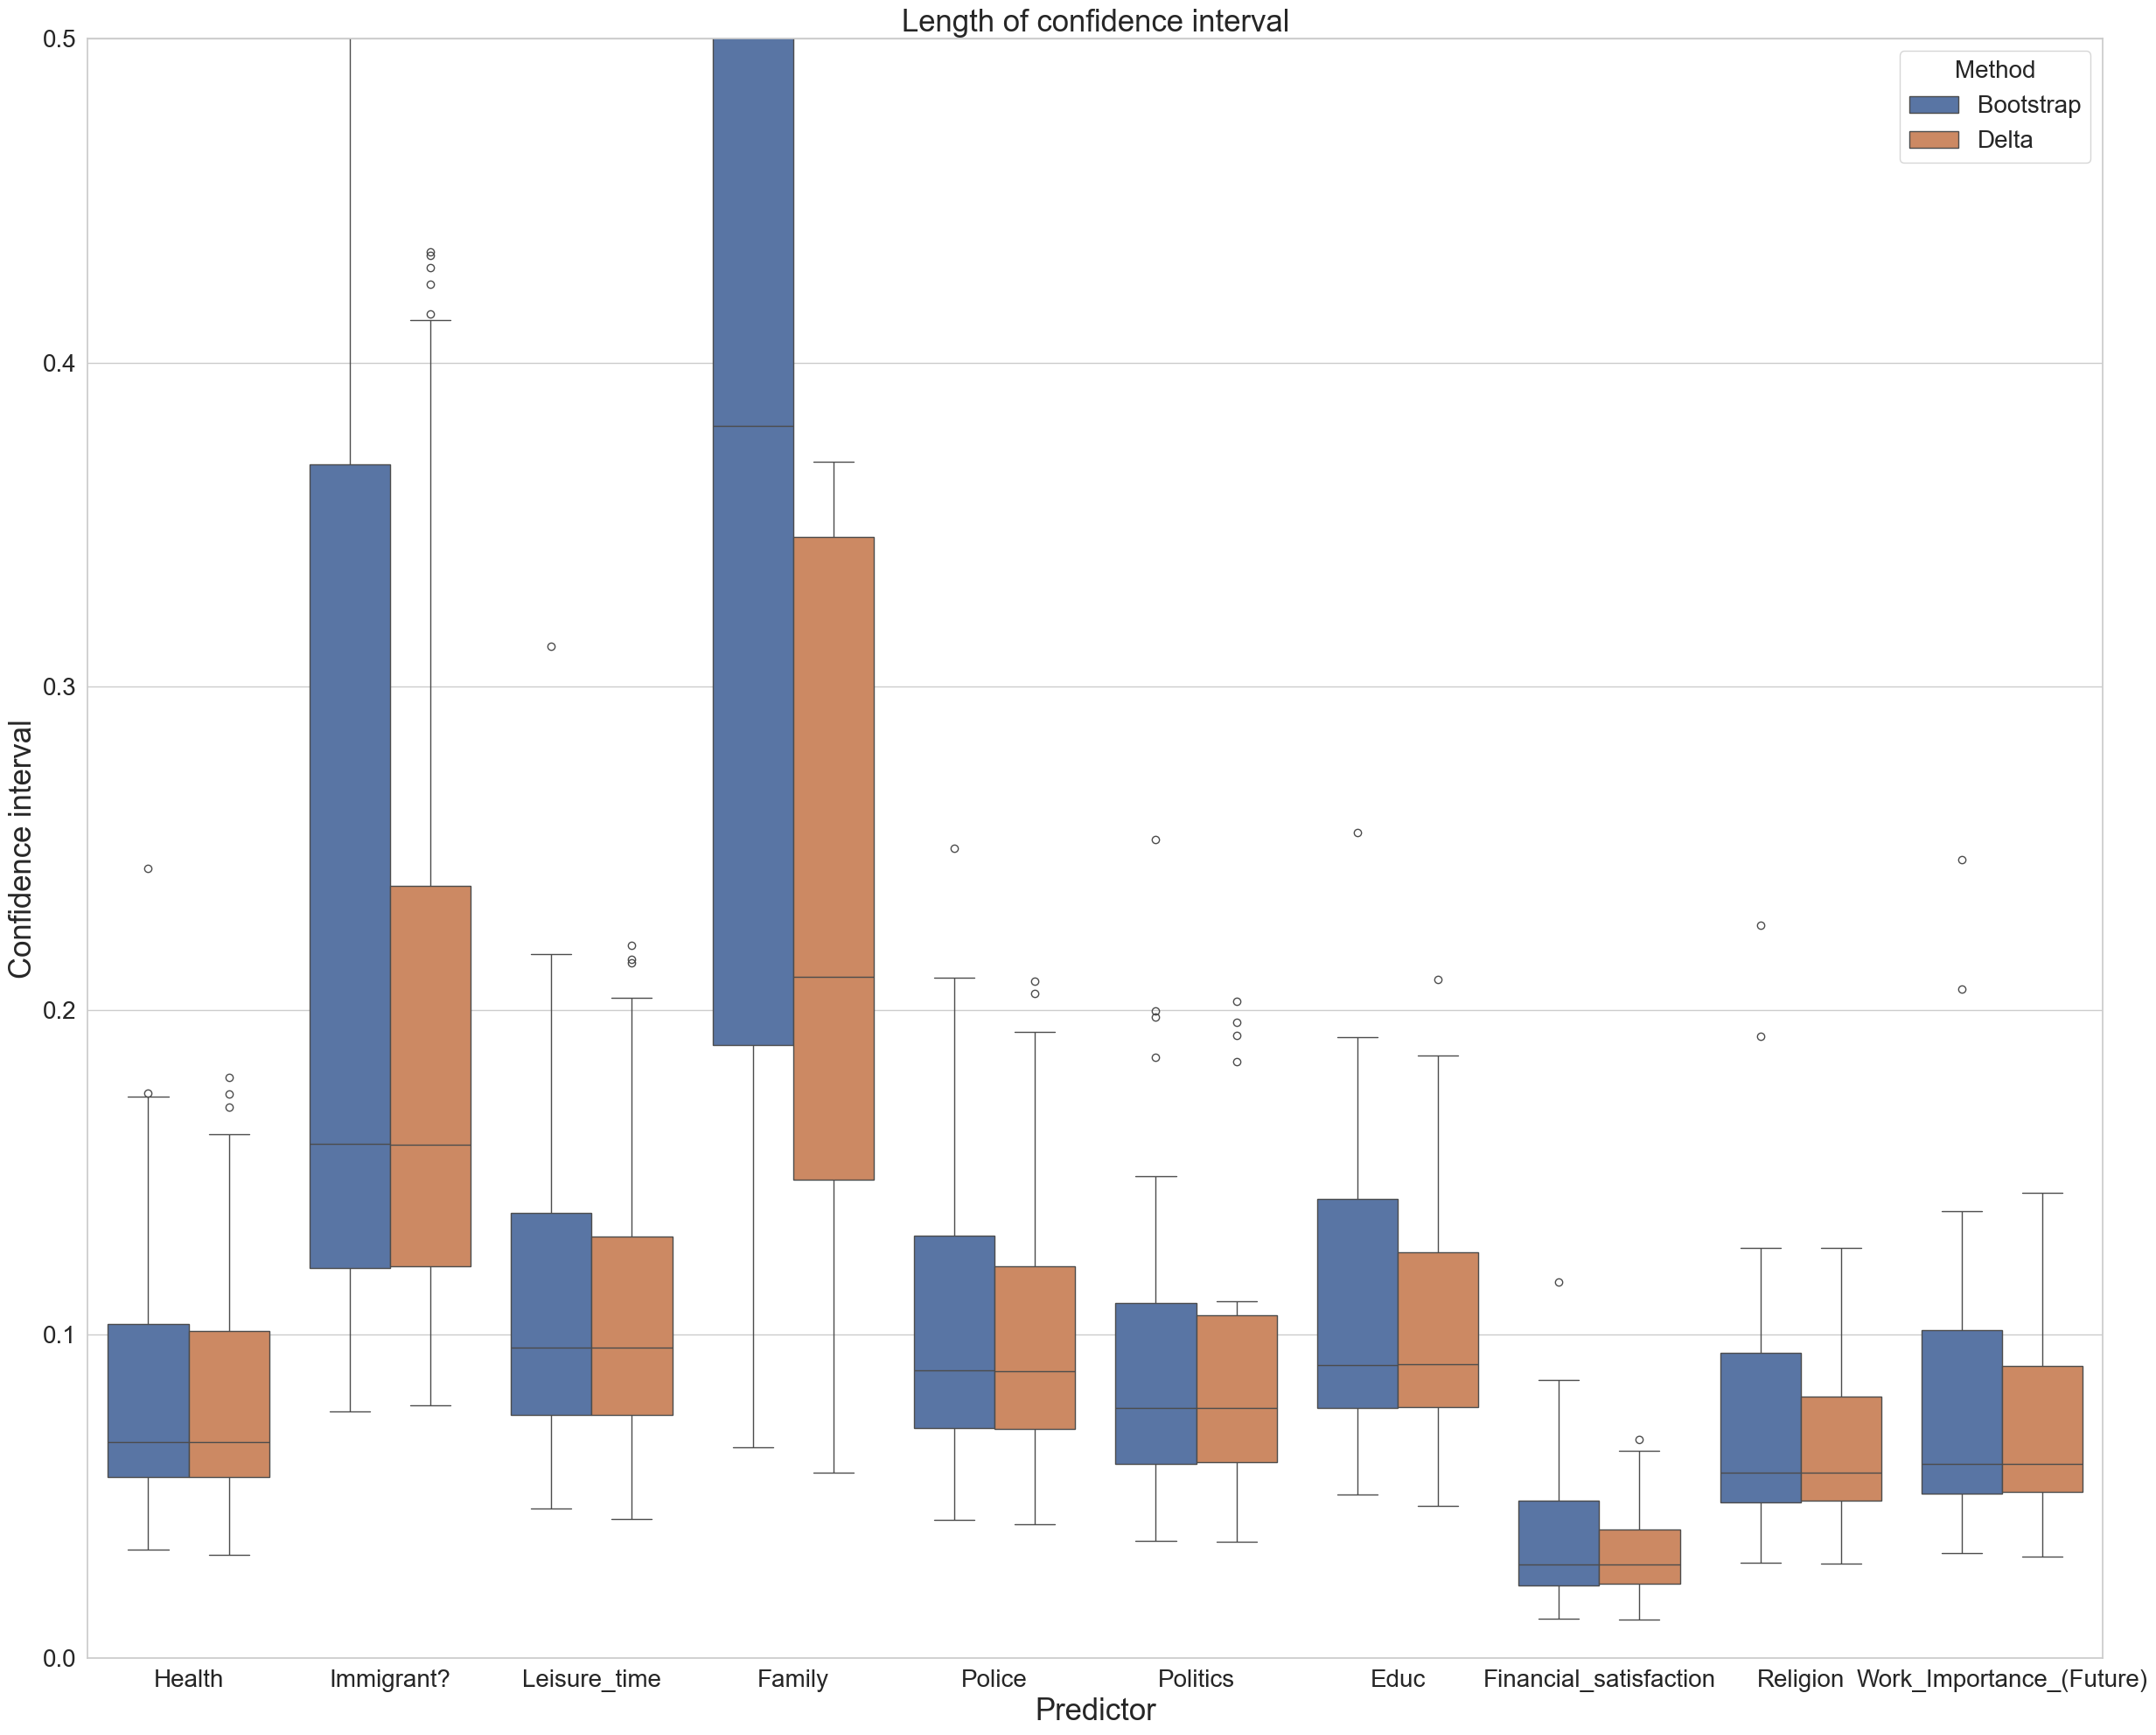

In [409]:
# === График 1: Длина доверительных интервалов ===
plt.figure(figsize=(25, 20))
sns.boxplot(data=combined_df, x='predictor', y='ci_length', hue='method')
plt.ylim(0, 0.5)
plt.title("Length of confidence interval")
plt.xlabel("Predictor")
plt.ylabel("Confidence interval")
plt.legend(title="Method",title_fontsize=20, fontsize=20)
plt.tight_layout()
plt.savefig("C:/Users/user/Desktop/Seminar/Excel_files/Length_of_confidence_interval.png", dpi=300, bbox_inches='tight')
plt.show()

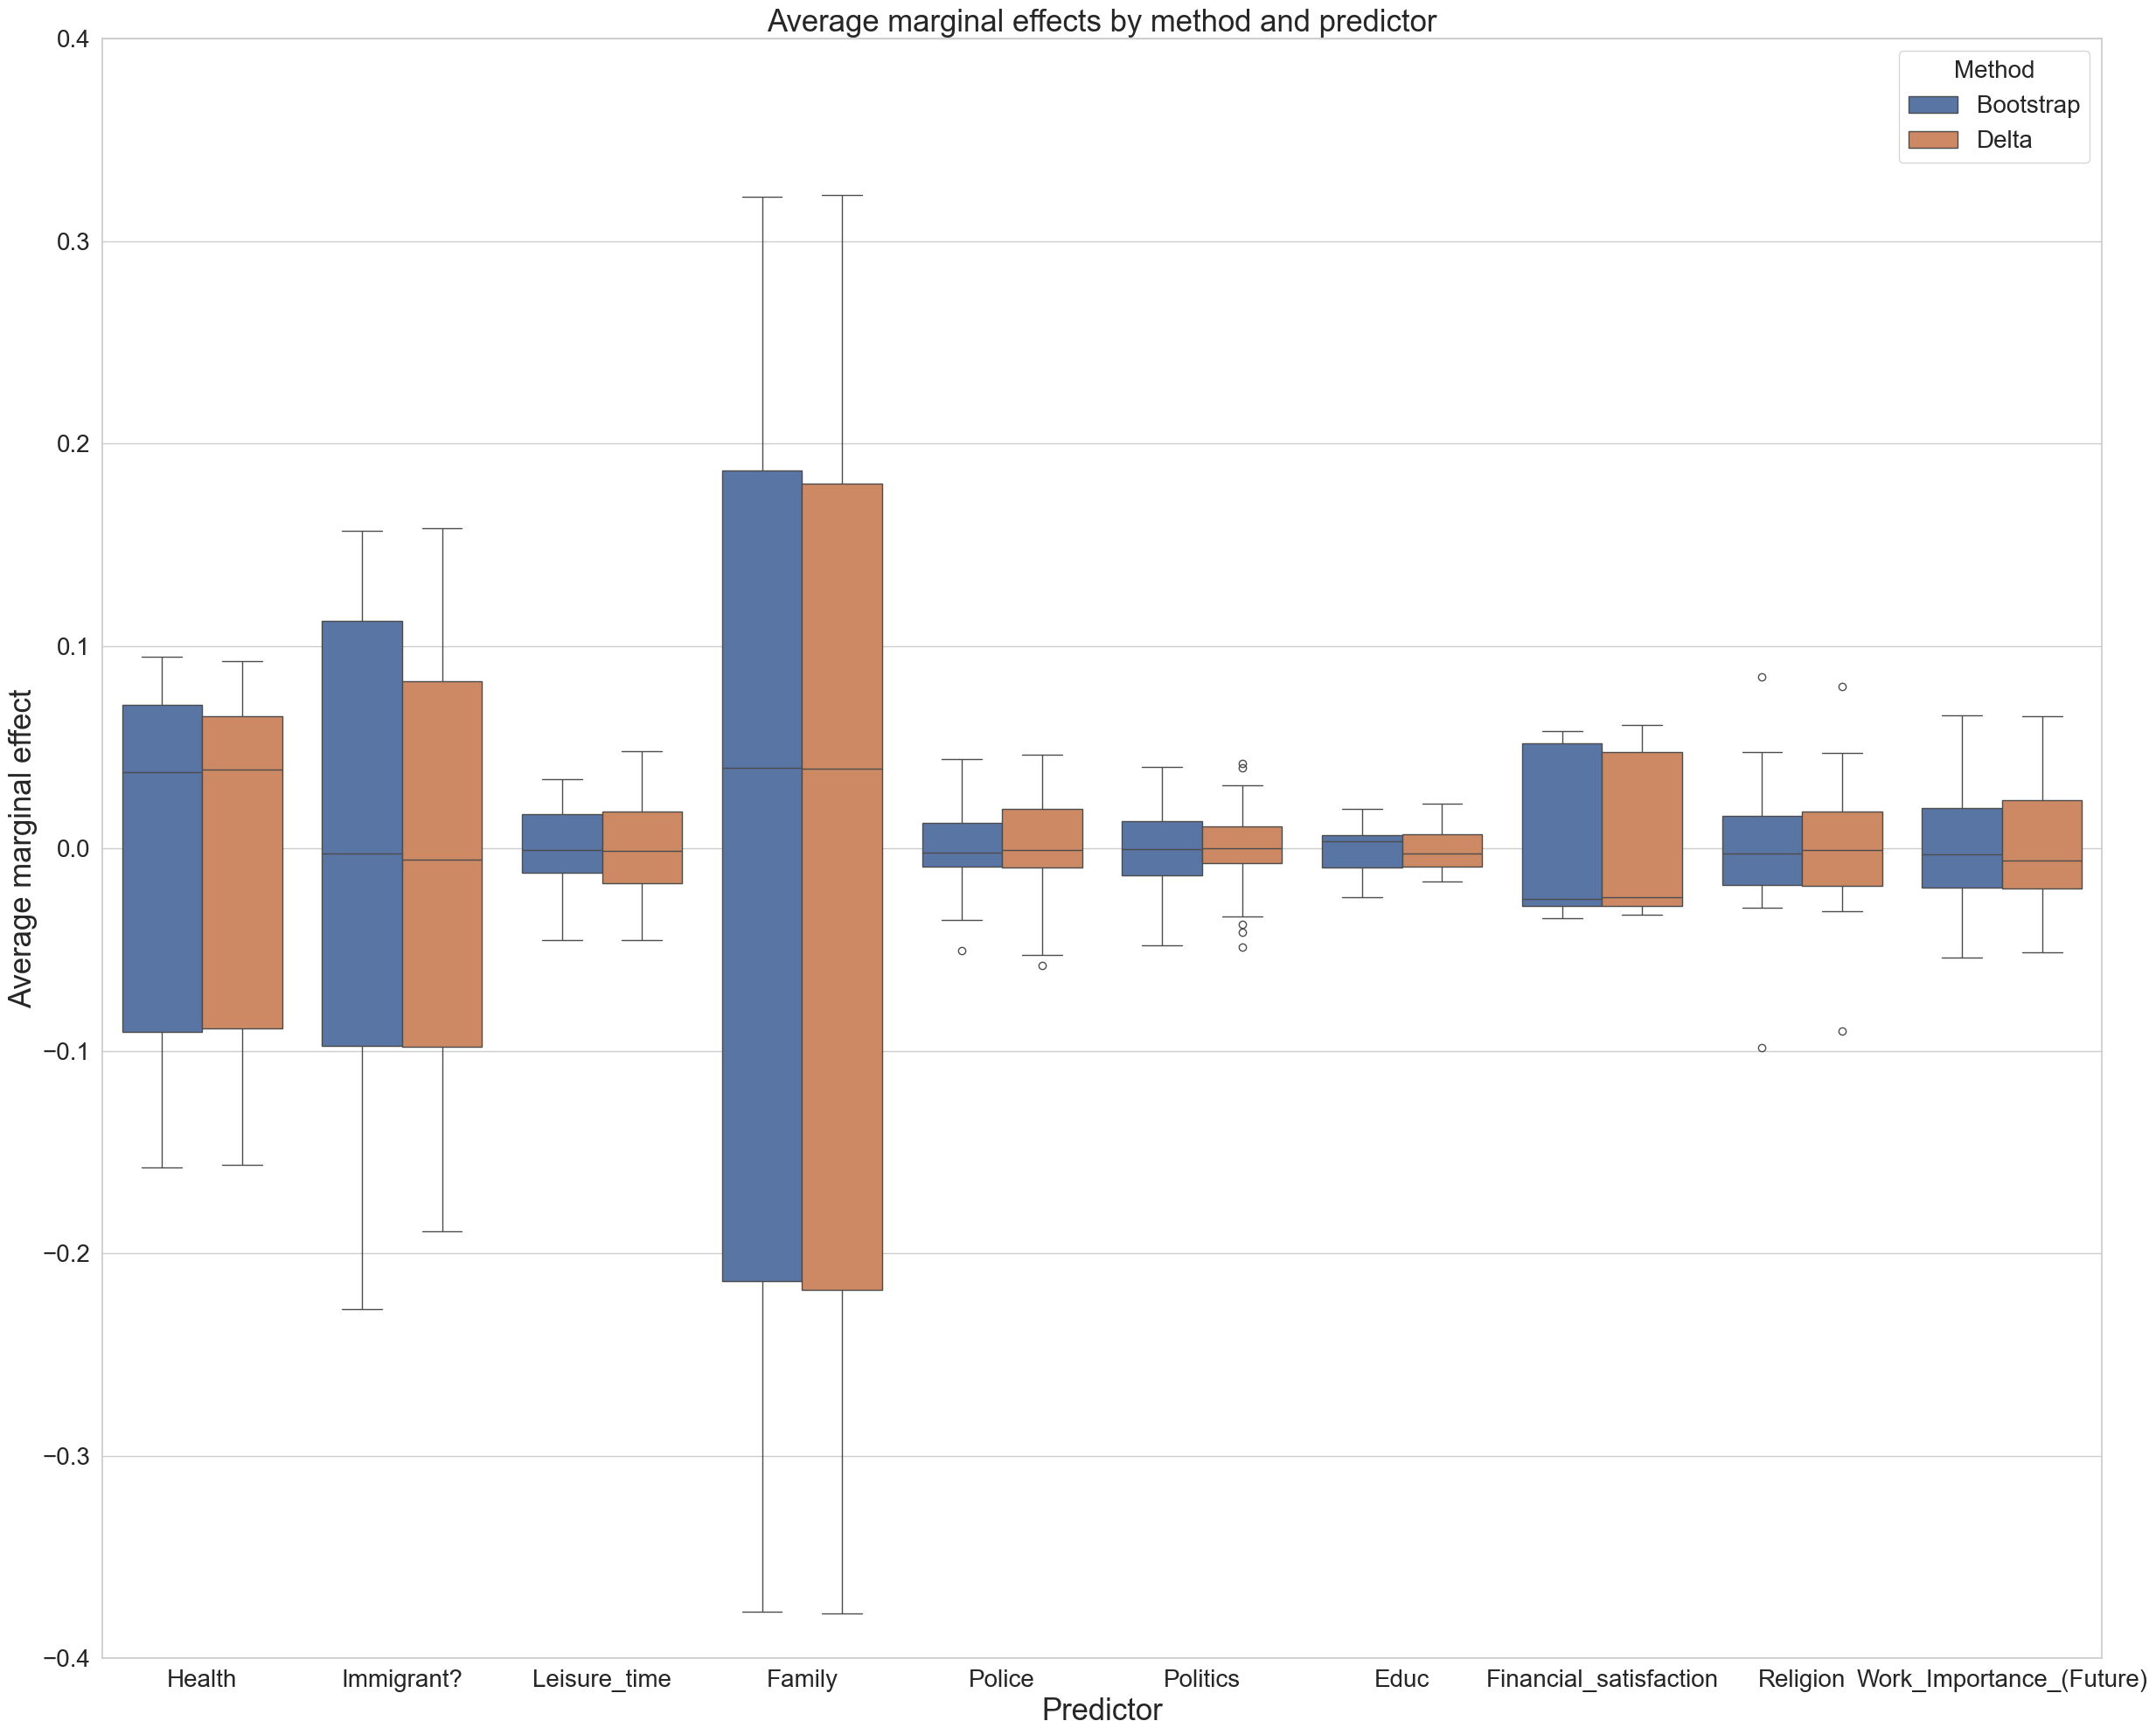

In [406]:
# === График 2: Маржинальные эффекты ===
plt.figure(figsize=(25, 20))
sns.boxplot(data=combined_df, x='predictor', y='mean_me', hue='method')
plt.title("Average marginal effects by method and predictor")
plt.xlabel("Predictor")
plt.ylabel("Average marginal effect")
plt.ylim(-0.4, 0.4)
plt.legend(title="Method",title_fontsize=20, fontsize=20)
plt.tight_layout()
plt.savefig("C:/Users/user/Desktop/Seminar/Excel_files/Average_marginal_effects.png", dpi=300, bbox_inches='tight')
plt.show()

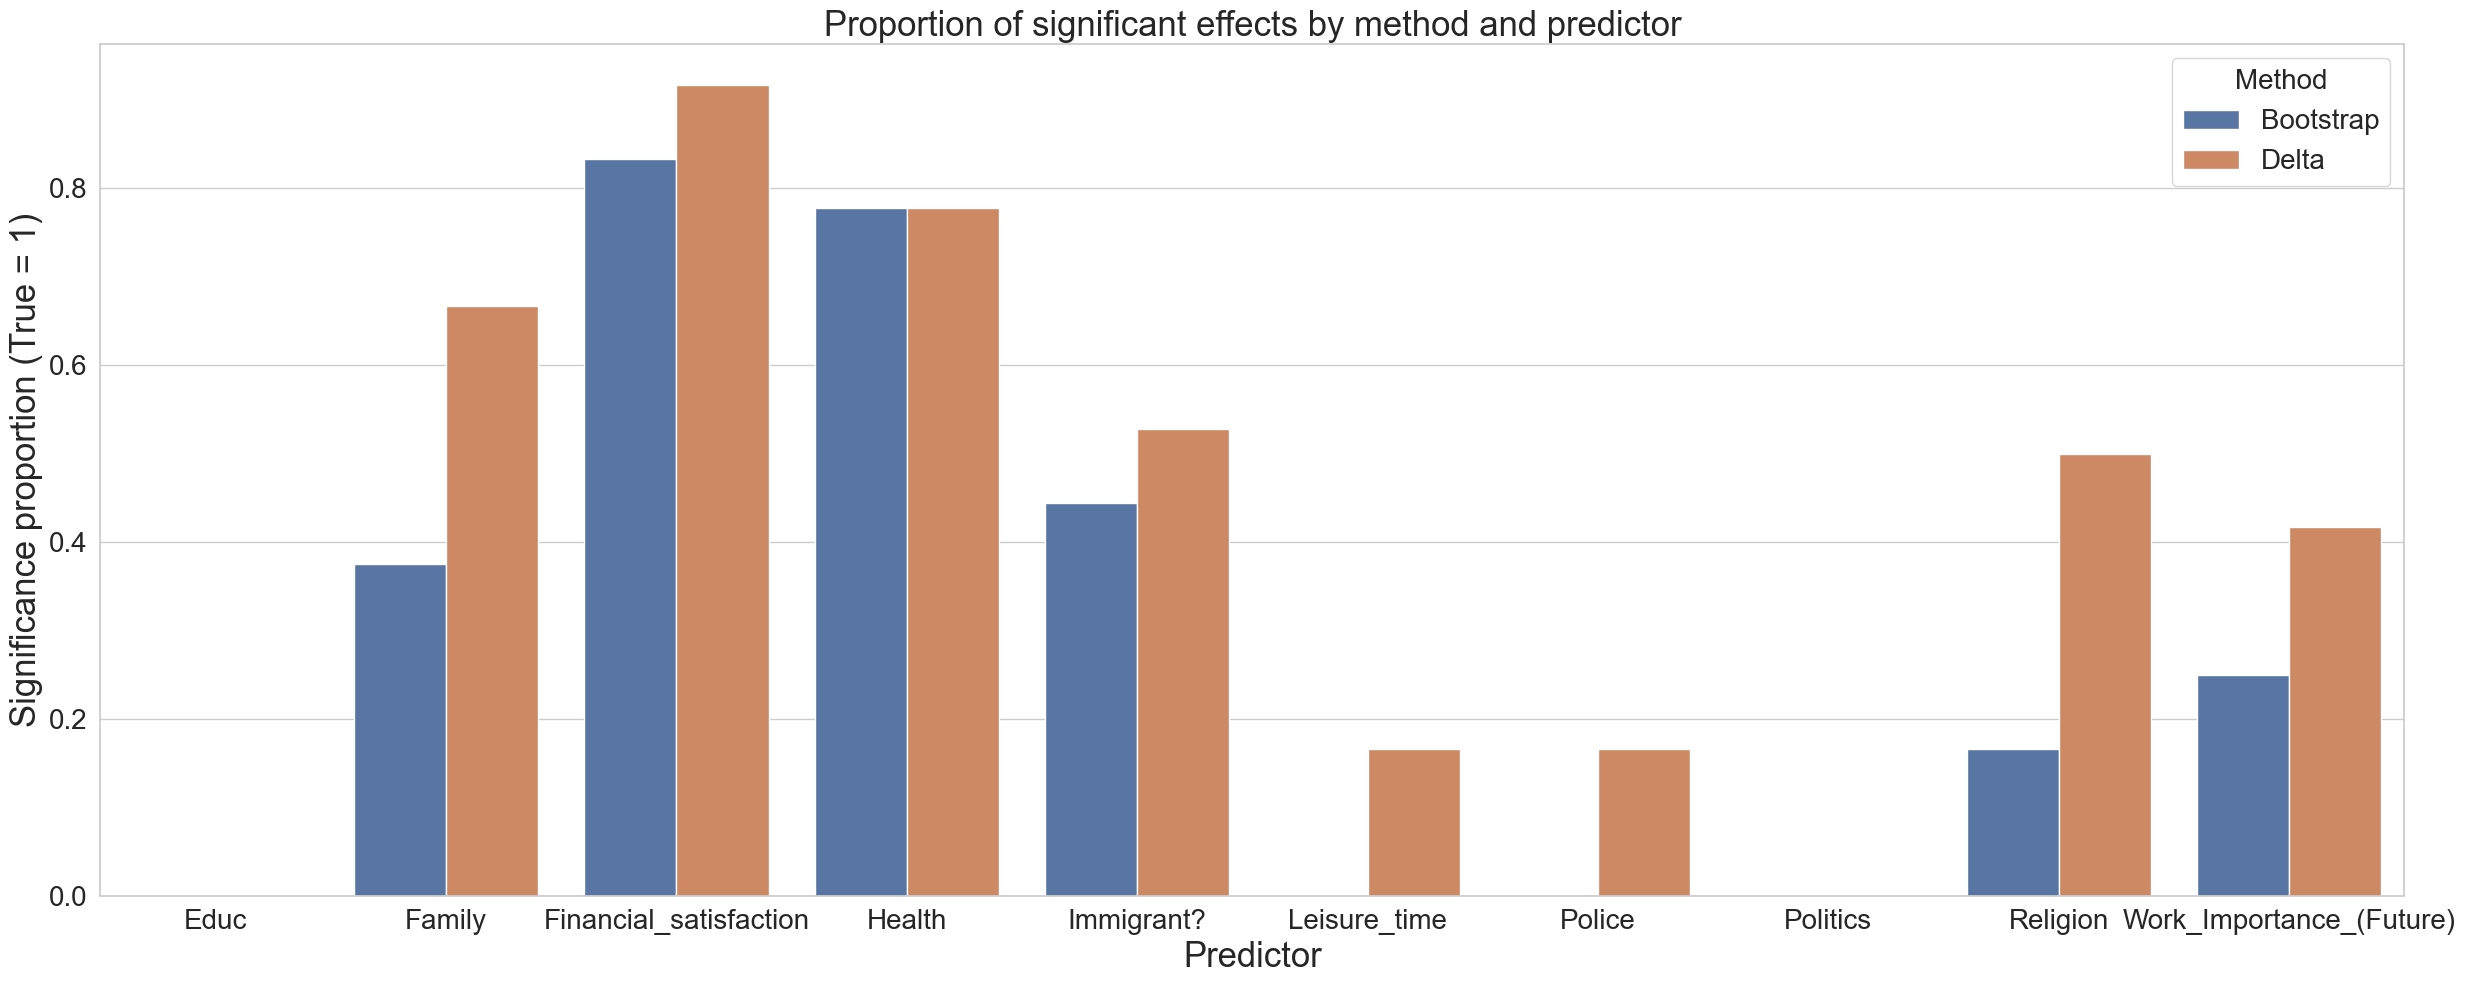

In [401]:
# === График 3: Доля значимых эффектов ===
significance = combined_df.groupby(['method', 'predictor'])['significant'].mean().reset_index()

plt.figure(figsize=(25, 10))
sns.barplot(data=significance, x='predictor', y='significant', hue='method')
plt.title("Proportion of significant effects by method and predictor")
plt.xlabel("Predictor")
plt.ylabel("Significance proportion (True = 1)")
plt.legend(title="Method",title_fontsize=20, fontsize=20)
plt.tight_layout()
plt.savefig("C:/Users/user/Desktop/Seminar/Excel_files/Proportion_of_significant_effects.png", dpi=300, bbox_inches='tight')
plt.show()

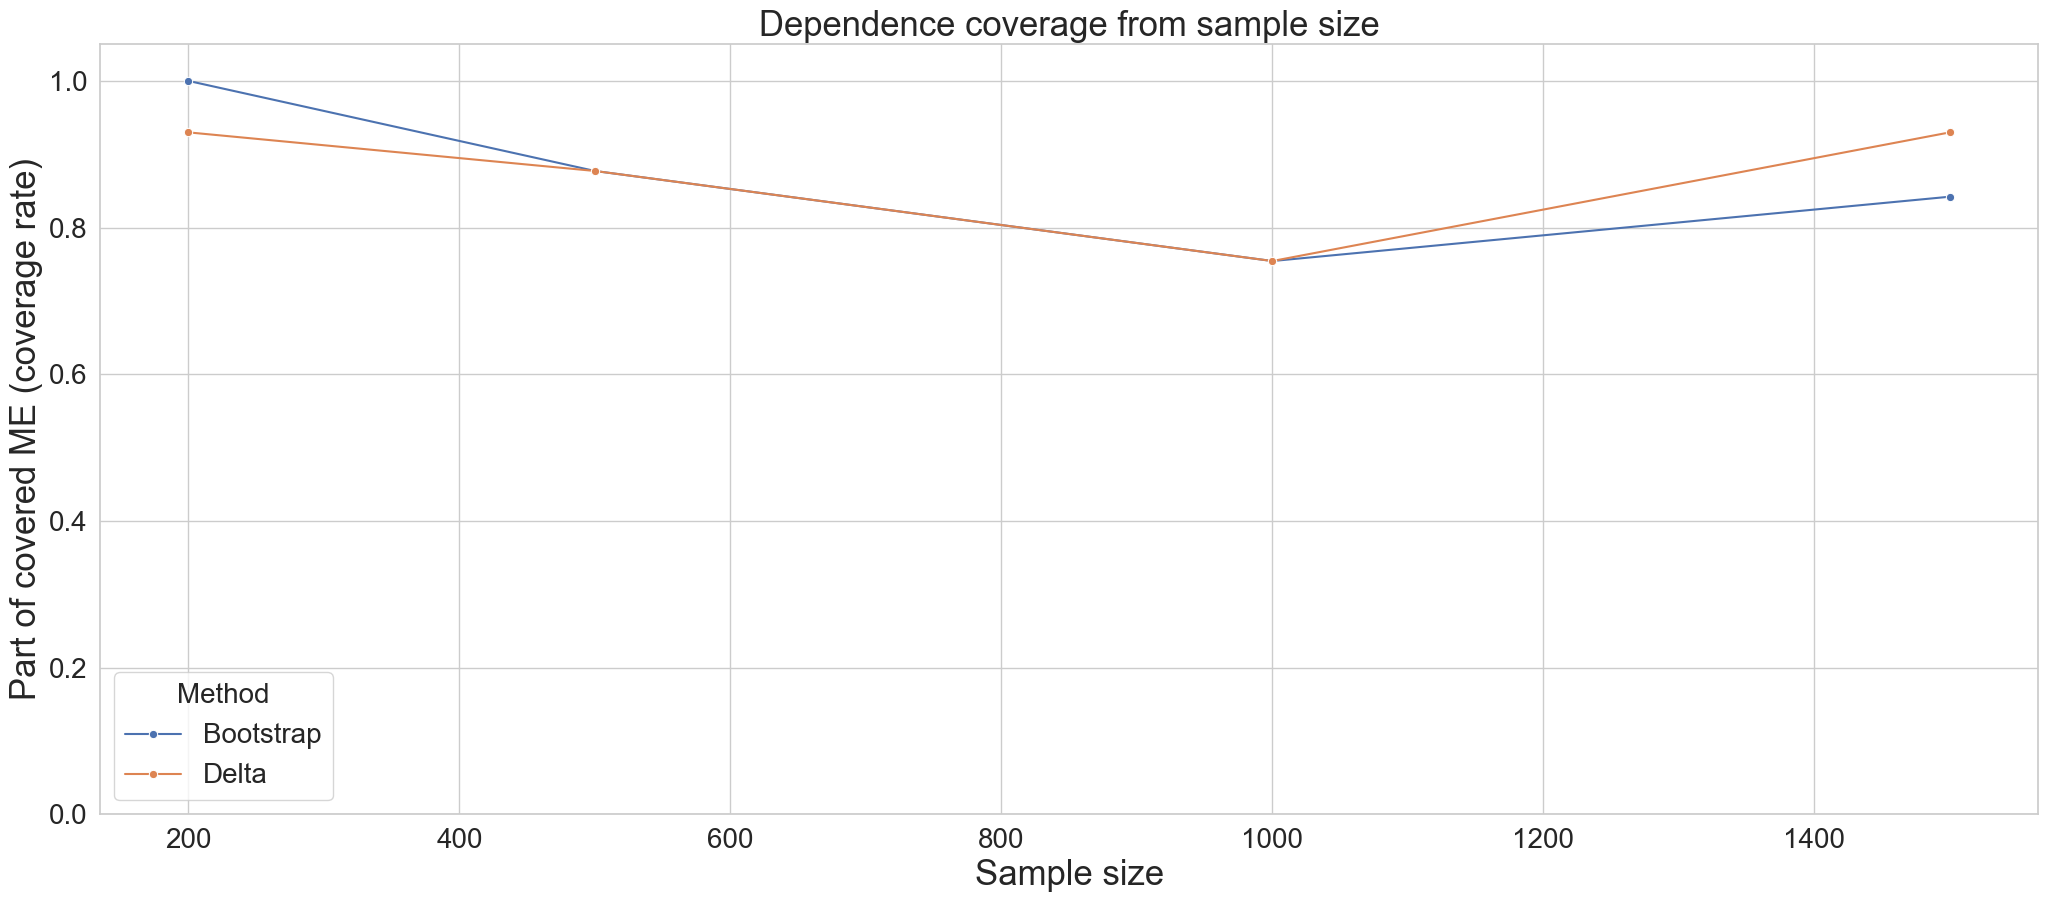

In [403]:
# === Группировка: считаем среднюю долю покрытых эффектов по sample_size и методу ===
coverage_by_sample = combined_df.groupby(['sample_size', 'method'])['covered'].mean().reset_index()

# === График ===
plt.figure(figsize=(25, 10))
sns.lineplot(data=coverage_by_sample, x='sample_size', y='covered', hue='method', marker='o',)

plt.title("Dependence coverage from sample size")
plt.xlabel("Sample size")
plt.ylabel("Part of covered ME (coverage rate)")
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend(title="Method",title_fontsize=20, fontsize=20)
plt.savefig("C:/Users/user/Desktop/Seminar/Excel_files/Dependence_coverage_from_samplesize.png", dpi=300, bbox_inches='tight')
plt.show()

In [377]:
combined_df.to_excel("C:/Users/user/Desktop/Seminar/Excel_files/combined_df_with_true_bootsanddelta.xlsx", index=False)